# for word2vec:
https://towardsdatascience.com/implementing-word2vec-in-pytorch-skip-gram-model-e6bae040d2fb
# for transD:
https://github.com/jimmywangheng/knowledge_representation_pytorch/
# for RNN:
https://pytorch.org/tutorials/intermediate/seq2seq_translation_tutorial.html

In [39]:
from collections import defaultdict, Counter
import networkx as nx
import numpy as np
import pylab as plt
import random
import torch
import torch.nn as nn
from copy import deepcopy
from torch import optim
import torch.nn.functional as F
from torch.autograd import Variable


# TransE

In [40]:
def marginLoss(pos, neg, margin):
    return torch.sum(torch.max(pos - neg + margin, torch.zeros(pos.size())))

def getBatchList(tripleList, num_batches):
    l = len(tripleList) // num_batches # batch_size
    v = []
    for i in range(num_batches-1):
        v.append(tripleList[l*i:l*(i+1)])
    v.append(tripleList[l*(num_batches-1):])
    return v

def getBatch_raw_all(tripleList):
    ph, pt ,pr = np.array(tripleList).T
    k=int(len(tripleList)/2)
    newTripleList=deepcopy(tripleList)
    np.random.shuffle(newTripleList[:k,0])# corrupt head/tail for half of data
    np.random.shuffle(newTripleList[k:,-1])
    nh, nt, nr = np.array(newTripleList).T
    return ph, pt, pr, nh, nt, nr

In [41]:
class transE(nn.Module):

    def __init__(self, entity_total, relation_total, embedding_size):
        super(transE, self).__init__()
        
        self.eE = nn.Embedding(entity_total, embedding_size) #embed entities
        self.rE = nn.Embedding(relation_total, embedding_size) #embed relation(s)

    def forward(self, pos_h, pos_t, pos_r, neg_h, neg_t, neg_r):
        
        pos_h_e = self.eE(pos_h)
        pos_t_e = self.eE(pos_t)
        pos_r_e = self.rE(pos_r)
        neg_h_e = self.eE(neg_h)
        neg_t_e = self.eE(neg_t)
        neg_r_e = self.rE(neg_r)
        
        pos = torch.sum((pos_h_e + pos_r_e - pos_t_e) ** 2, 1)
        neg = torch.sum((neg_h_e + neg_r_e - neg_t_e) ** 2, 1)
        return pos, neg
    
    def get_eE(self, inputs):
        return self.eE(inputs)

    def get_rE(self, inputs):
        return self.rE(inputs)
    

In [42]:
pairs

[(0, 0, 1),
 (1, 0, 2),
 (2, 0, 3),
 (3, 0, 4),
 (4, 0, 5),
 (5, 0, 6),
 (6, 0, 7),
 (7, 0, 8),
 (8, 0, 9)]

In [43]:
from random import choices


ImportError: cannot import name 'choices'

In [44]:
# parameters
num_batches=100
embedding_size=2
entity_total=10
relation_total=1
sample_size = 10000
pairs=list(zip(range(9),[0]*10,range(1,10)))
trainList=np.array(random.choices(pairs,k=sample_size))
trainBatchList = getBatchList(trainList, num_batches)
model = transE(entity_total, relation_total, embedding_size)
optimizer = optim.SGD(model.parameters(), lr=0.01) 

AttributeError: module 'random' has no attribute 'choices'

In [23]:
random.choices()

AttributeError: module 'random' has no attribute 'choices'

In [1869]:
pairs

[(0, 0, 1),
 (1, 0, 2),
 (2, 0, 3),
 (3, 0, 4),
 (4, 0, 5),
 (5, 0, 6),
 (6, 0, 7),
 (7, 0, 8),
 (8, 0, 9)]

In [1151]:
# model and training
num_epochs = 30
Loss=[]
for epo in range(num_epochs):
    loss_val = 0
    random.shuffle(trainBatchList)
    for batchList in trainBatchList:
        #
        optimizer.zero_grad()
        #
        pos_h_batch, pos_r_batch, pos_t_batch,  neg_h_batch, neg_r_batch , neg_t_batch\
        = getBatch_raw_all(batchList)
        pos_h_batch = Variable(torch.LongTensor(pos_h_batch))
        pos_t_batch = Variable(torch.LongTensor(pos_t_batch))
        pos_r_batch = Variable(torch.LongTensor(pos_r_batch))
        neg_h_batch = Variable(torch.LongTensor(neg_h_batch))
        neg_t_batch = Variable(torch.LongTensor(neg_t_batch))
        neg_r_batch = Variable(torch.LongTensor(neg_r_batch))
        pos, neg = model(pos_h_batch, pos_t_batch, pos_r_batch,\
                         neg_h_batch, neg_t_batch, neg_r_batch)
        losses = marginLoss(pos, neg, 1)        
        loss_val += losses.item()
        losses.backward()
        optimizer.step()
        
    
    if epo % 10 == 0:    
        print(f'Loss at epo {epo}: {loss_val/len(idx_pairs)}')
    Loss.append(loss_val/len(idx_pairs))        

Loss at epo 0: 30.896306924819946
Loss at epo 10: 12.12
Loss at epo 20: 12.74


Text(0,0.5,'Loss')

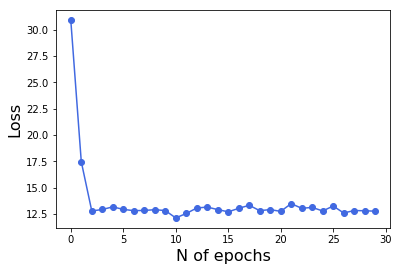

In [1152]:
plt.plot(Loss,color='RoyalBlue',marker='o')
plt.xlabel('N of epochs',fontsize=16)
plt.ylabel('Loss',fontsize=16)

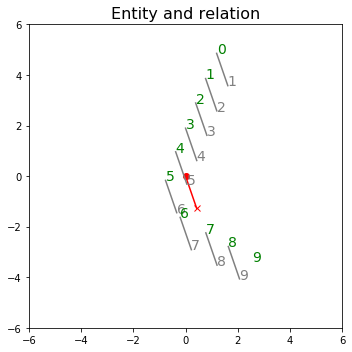

In [1189]:
posR=dict(zip(range(10),model.get_rE(Variable(torch.LongTensor([0]))).data.numpy()))
posE=dict(zip(range(10),model.get_eE(Variable(torch.LongTensor(range(10)))).data.numpy()))
#
fig = plt.figure(figsize=(5, 5),facecolor='white')
ax = fig.add_subplot(111)
plt.title('Entity and relation',fontsize=16)
#
x,y=posR[0]
plt.plot(0,0,'ro')
plt.plot(x,y,'rx')
plt.plot([0,x],[0,y],'r-')
#
for i in range(9):
    x,y=posE[i]
    x_new,y_new=posE[i]+posR[0]
    plt.text(x,y,i,size=14,color='green')
    plt.text(x_new,y_new,i+1,size=14,color='gray')
    plt.plot([x,x_new],[y,y_new],color='gray')
    
x,y=posE[9]
plt.text(x,y,9,size=14,color='green')
#
l=6
plt.xlim(-l,l)
plt.ylim(-l,l)
#
#
plt.tight_layout()
plt.show()

In [38]:
weighted_choices = [('Red', 3), ('Blue', 2), ('Yellow', 1), ('Green', 4)]